In [1]:
%%capture
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install matplotlib==3.5 #with newer versions of matplotlib this notebook might not run
%matplotlib inline
!pip install captum==0.5

from matplotlib import cm
from matplotlib import patches
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import torch # pytorch
import torch.nn as nn # weights and biases tensors
import torch.nn.functional as F # activation functions
import torchvision.transforms as T # transformations
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from pathlib import Path
from PIL import Image, ImageDraw
import torchvision.datasets as datasets
import torchvision.models as models
import random
from torch.utils.data import Subset
import matplotlib.pyplot as plt
import csv
import cv2
from torchvision.datasets import ImageFolder
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm.auto import tqdm
import time
from torchvision.ops import nms

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.transforms import functional as F
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#We can use our GPU if it's available
print(torch.cuda.is_available())
dev = torch.device('cuda')
print(dev)

In [2]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

albumentations==1.3.1 is successfully installed


## Importing the dataset

In [3]:
# read the csv file using read_csv function of pandas
df_train = pd.read_csv('/kaggle/input/aiunict-2023/train.csv')
df_test = pd.read_csv('/kaggle/input/aiunict-2023/test.csv')
df_train['image'] = df_train['image'].str.slice(start=3)
df_test['image'] = df_test['image']
df_train['class'] = df_train['class'] + 1

## Let's create the Dataset class

In [4]:
############# train ##############
class AIUNICT2023_train(Dataset):
    def __init__(self, df, image_dir, train=True, transforms=None): #transforms = T.Compose
        super().__init__() # inherit from Dataset
        split = "train"
        self.df = df
        self.image_dir = Path(image_dir)/split
        self.transforms = transforms
        self.classes = sorted(os.listdir(Path(image_dir)/split))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i): # accessing images
        class_index = i // len(os.listdir(os.path.join(self.image_dir, self.classes[0])))
        class_dir = os.path.join(self.image_dir, self.classes[class_index])
        file_index = i % len(os.listdir(class_dir))
        filename = os.listdir(class_dir)[file_index]
        image_path = os.path.join(class_dir, filename)
        img = Image.open(image_path).convert('RGB')
    
        
            
        # get the bounding box coordinates and labels for the image
        boxes = []
        labels = []
        for _, row in self.df[self.df['image'] == filename].iterrows():
            xmin = row['x1']
            ymin = row['y1']
            xmax = row['x2']
            ymax = row['y2']
            xmin =xmin+1
            xmax =xmax-1
            ymin = ymin+1
            ymax =ymax-1
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(row['class'])
            
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        if self.transforms:
            transformed = self.transforms(image = np.array(img), bboxes = target['boxes'], labels = target['labels'])
            #Convert transformed image back to PIL Image
            img = Image.fromarray(transformed['image'])

            # Update target boxes and labels
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)
            target['labels'] = torch.tensor(transformed['labels'], dtype=torch.int64)
            return img, target, filename
        
        return img, target, filename
        
    
################## test set ###########################
class AIUNICT2023_test(Dataset):
    def __init__(self, df, dest_dir, train = False, transforms=None):
        split = "test"
        self.df = df
        self.dest_dir = Path(dest_dir)/split
        self.transforms = transforms
        self.image_ids = self.df['image']
      #  self.files = os.listdir(self.dest_dir)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        img_id = self.image_ids[i]
        img = Image.open(self.dest_dir/img_id).convert("RGB")

        # get the bounding box coordinates and labels for the image
        boxes = []
        for _, row in self.df[self.df['image'] == img_id].iterrows():
            xmin = row['x1']
            ymin = row['y1']
            xmax = row['x2']
            ymax = row['y2']
            boxes.append([xmin, ymin, xmax, ymax])
            
        boxes = torch.tensor(boxes, dtype=torch.float32)

        target = {}
        target['boxes'] = boxes
        

        return img, target, img_id


###################
# batches of data
def collate_fn(batch): 
    return tuple(zip(*batch))

## Let's define some transformations 

In [5]:
bbox_params = {'format': 'pascal_voc', 'label_fields': ['labels']}
def transform():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.GridDistortion(distort_limit=0.2, p=0.3)
     #   A.ShiftScaleRotate(p=0.5),                  
     #   ToTensorV2(),
    ],
    bbox_params = bbox_params
 )

## Defining training and test set

In [6]:
dest_dir = "/kaggle/input/aiunict-2023"
train_set = AIUNICT2023_train(df_train, dest_dir, train=True, transforms=transform())
test_set = AIUNICT2023_test(df_test, dest_dir, train = False, transforms=None)

In [7]:
print(f"{len(train_set)} samples used as train set")
print(f"{len(test_set)} samples used as test set")

1600 samples used as train set
800 samples used as test set


In [8]:
train_loader = DataLoader(train_set, batch_size=10, shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=2) #shuffle = True means that for each epoch data are shuffled


# Let's visualize some images with bounding boxes

In [9]:
img, target, _ = train_set[1]
print(target)

{'boxes': tensor([[ 27.,  96., 157., 229.]]), 'labels': tensor([1])}


In [10]:
img, target, _ = test_set[200]
print(target)

{'boxes': tensor([[203.,  81., 330., 208.]])}


In [11]:
images, targets, _= next(iter(train_loader))
boxes = targets[0]['boxes']
boxes.shape

torch.Size([1, 4])

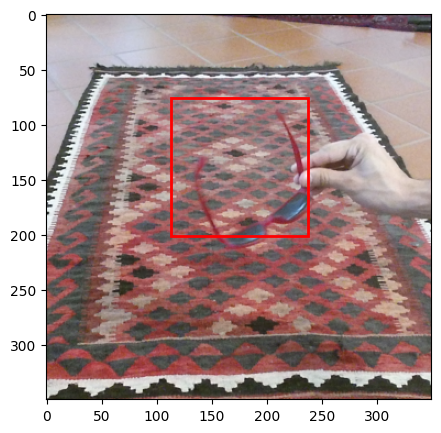

05_060.png


In [12]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in (target['boxes']):
        box = box.cpu().numpy()
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes.
img, target, filename = train_set[1000]
plot_img_bbox(img, target)
print(filename)

## The backbone Model

For this experiment three differnt backbone models have been used:
- ResNet50 FPN
- ResNet50 FPN v2
- MobileNet


In [13]:
# importing the models

from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

In [14]:
model = fasterrcnn_resnet50_fpn_v2(weights='DEFAULT') # pre-trained
num_classes = 9 

# replace the classifier with a new one, that has # num_classes which is user-defined
in_features = model.roi_heads.box_predictor.cls_score.in_features
# # replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 226MB/s]  


In [15]:
#The Averager class is for keeping track of the training and validation loss values. 
#We can also retrieve the average loss after each epoch with help of instances of this class
class Averager:
    def __init__(self):
        self.current_total = 0.0 #total loss
        self.iterations = 0.0 # n of iterations
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

## Let's visualize the model's architecture 

In [16]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [17]:
# Define an optimizier - Stochastic Gradient Descent 
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.005, weight_decay = 0.0008) #default weight_decay= 0.001   
# Define a loss - Contss Entropy Loss 
criterion = nn.CrossEntropyLoss()

In [18]:
# function for running training iterations
def train(train_loader, model):
    print('Training')
    global train_itr
    global train_loss_list
    model.to(dev)

    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_loader, total=len(train_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets, _ = data
        
        images = list(T.ToTensor()(image).to(dev) for image in images)
        targets = [{k: v.to(dev) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        train_loss_hist.send(loss_value)
        losses.backward()
        optimizer.step()
        train_itr += 1
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

In [19]:
num_epochs = 6
# initialize the Averager class
train_loss_hist = Averager()

train_loss_list = []

train_itr = 0

for epoch in range(num_epochs):
    print(f"\nEPOCH {epoch+1} of {num_epochs}")
    # reset the training and validation loss histories for the current epoch
    train_loss_hist.reset()
    #val_loss_hist.reset()
    # start timer and carry out training and validation
    start = time.time()   
    train_loss = train(train_loader, model) #loader con solo le immagini originali di training
    
# THE LOSS IS UPDATED IN EACH ITERATION


EPOCH 1 of 6
Training


  0%|          | 0/160 [00:00<?, ?it/s]


EPOCH 2 of 6
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78da8f59dbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78da8f59dbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op


EPOCH 3 of 6
Training


  0%|          | 0/160 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78da8f59dbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78da8f59dbd0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op


EPOCH 4 of 6
Training


  0%|          | 0/160 [00:00<?, ?it/s]


EPOCH 5 of 6
Training


  0%|          | 0/160 [00:00<?, ?it/s]


EPOCH 6 of 6
Training


  0%|          | 0/160 [00:00<?, ?it/s]

# Decode Predictions

In [20]:
def apply_nms(orig_prediction, iou_thresh=0.3): # apply Non-Maximum Suppression
    # iou_thresh=0.3 - Intersection over Union threshold
    # torchvision returns the indices of the bboxes to keep
    keep = nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return T.ToPILImage()(img).convert('RGB')

In [21]:
def test_accuracy(model):
    with torch.no_grad():
        # Create an empty list to hold the results
        results = []
        model.eval()
        for i in range(test_set.__len__()):
            img, _, img_id = test_set[i]
            prediction = model([T.ToTensor()(img).to(dev)])[0]
            nms_prediction = apply_nms(prediction, iou_thresh=0.3)
            x = nms_prediction['labels'].tolist()
    #        x = x - 1
            if len(x) > 0:
                x = x[0]
                x = x - 1 #because I increased the labels before since FasteRCNN has problem with label 0 (reserved for background)
            else:
                x = ""
            results.append([img_id, x])

        #Write the results to a CSV file
        with open('/kaggle/working/submission.csv', 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['image', 'class'])
            writer.writerows(results)
        
test_accuracy(model)  

# Let's see an example of comparison between ground truth bbox and predicted bbox

In [22]:
# pick one image from the test set
img, target, img_id = test_set[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([T.ToTensor()(img).to(dev)])[0]
    
    nms_prediction = apply_nms(prediction, iou_thresh=0.3)
    print('predicted #boxes: ', len(nms_prediction['labels']))
    print(nms_prediction['labels'].tolist()[0])

predicted #boxes:  1
3


EXPECTED OUTPUT


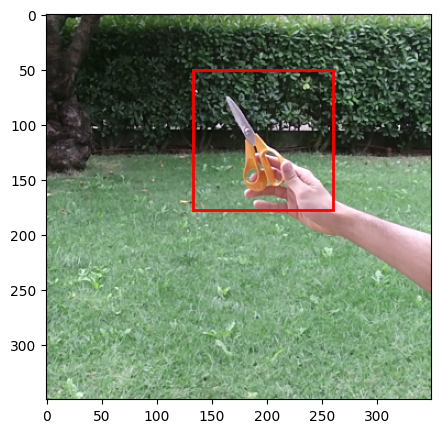

In [23]:
print('EXPECTED OUTPUT')
plot_img_bbox(img, target)

MODEL OUTPUT


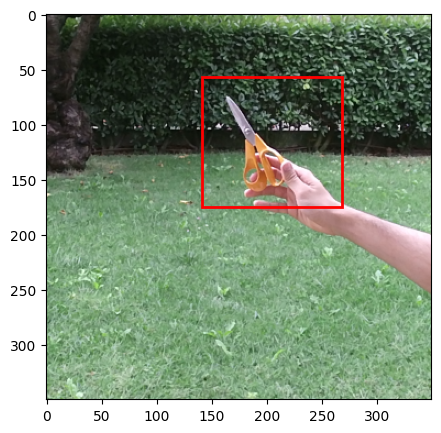

In [24]:
print('MODEL OUTPUT')
plot_img_bbox(img, prediction)

In [25]:
torch.save(model.state_dict(), '/kaggle/working/AIUNICT.pth')
torch.save(model, '/kaggle/working/AIUNICTentire.pth')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/kaggle/working/AIUNICTmodel_scripted.pt') # Save